<a href="https://colab.research.google.com/github/VandhanaV/Richetors-predictor-/blob/master/RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import files
#import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab
%matplotlib inline
import seaborn as sns
from google.colab import drive
import pandas_profiling 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score,accuracy_score, recall_score, f1_score,roc_auc_score,classification_report,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import kurtosis



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
#pd.read_csv(io.BytesIO(uploaded1['train_labels.csv']))
train_label = pd.read_csv("https://raw.githubusercontent.com/VandhanaV/Richetors-predictor-/master/train_labels.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/VandhanaV/Richetors-predictor-/master/test_values.csv")
train_feat = pd.read_csv("https://raw.githubusercontent.com/VandhanaV/Richetors-predictor-/master/train_values.csv")

In [0]:
train_feat.set_index('building_id',inplace=True)
train_label.set_index('building_id',inplace=True)
df=pd.concat([train_feat,train_label], axis=1, join='inner')

In [4]:
mem = df.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   79.52911376953125 MB


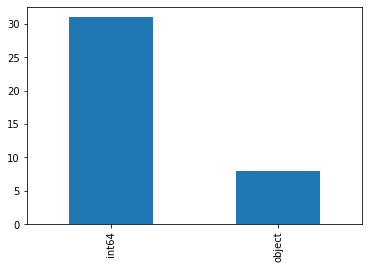

In [5]:
pp = pd.value_counts(df.dtypes)
pp.plot.bar()
plt.show()

In [6]:
df.head().T

building_id,802906,28830,94947,590882,201944
geo_level_1_id,6,8,21,22,11
geo_level_2_id,487,900,363,418,131
geo_level_3_id,12198,2812,8973,10694,1488
count_floors_pre_eq,2,2,2,2,3
age,30,10,10,10,30
area_percentage,6,8,5,6,8
height_percentage,5,7,5,5,9
land_surface_condition,t,o,t,t,t
foundation_type,r,r,r,r,r
roof_type,n,n,n,n,n


In [0]:
def null_check(df):
  for column in df.columns:
    if(df[column].isnull().sum()!=0):
      print("Percentage of missing values in {} type {} is: {:.2f}".format(column,df[column].dtype, (df[column].isnull().sum()*100)/len(df)))
    else:
      break
#df.isnull().values.any()

In [0]:
null_check(df)

In [0]:
num_des=df.describe().T
#add more cols
#num_des['type']=num_des

In [10]:
des=df.describe(include='object').T
des['top %'] = des['freq'].apply(lambda x:round((x/len(df))*100,2))
des

,count,unique,top,freq,top %
land_surface_condition,260601,3,t,216757,83.18
foundation_type,260601,5,r,219196,84.11
roof_type,260601,3,n,182842,70.16
ground_floor_type,260601,5,f,209619,80.44
other_floor_type,260601,4,q,165282,63.42
position,260601,4,s,202090,77.55
plan_configuration,260601,10,d,250072,95.96
legal_ownership_status,260601,4,v,250939,96.29


In [11]:
#divide the columns into three types

bin_cols=[col for col in train_feat.select_dtypes(exclude='object') if np.isin(train_feat[col].unique(), [0, 1]).all()]
cat_cols=df.select_dtypes(include='object').columns.tolist()
non_bin_cols=[col for col in train_feat.select_dtypes(exclude='object') if np.logical_not(np.isin(train_feat[col].unique(), [0, 1])).any()]
cat_cols

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

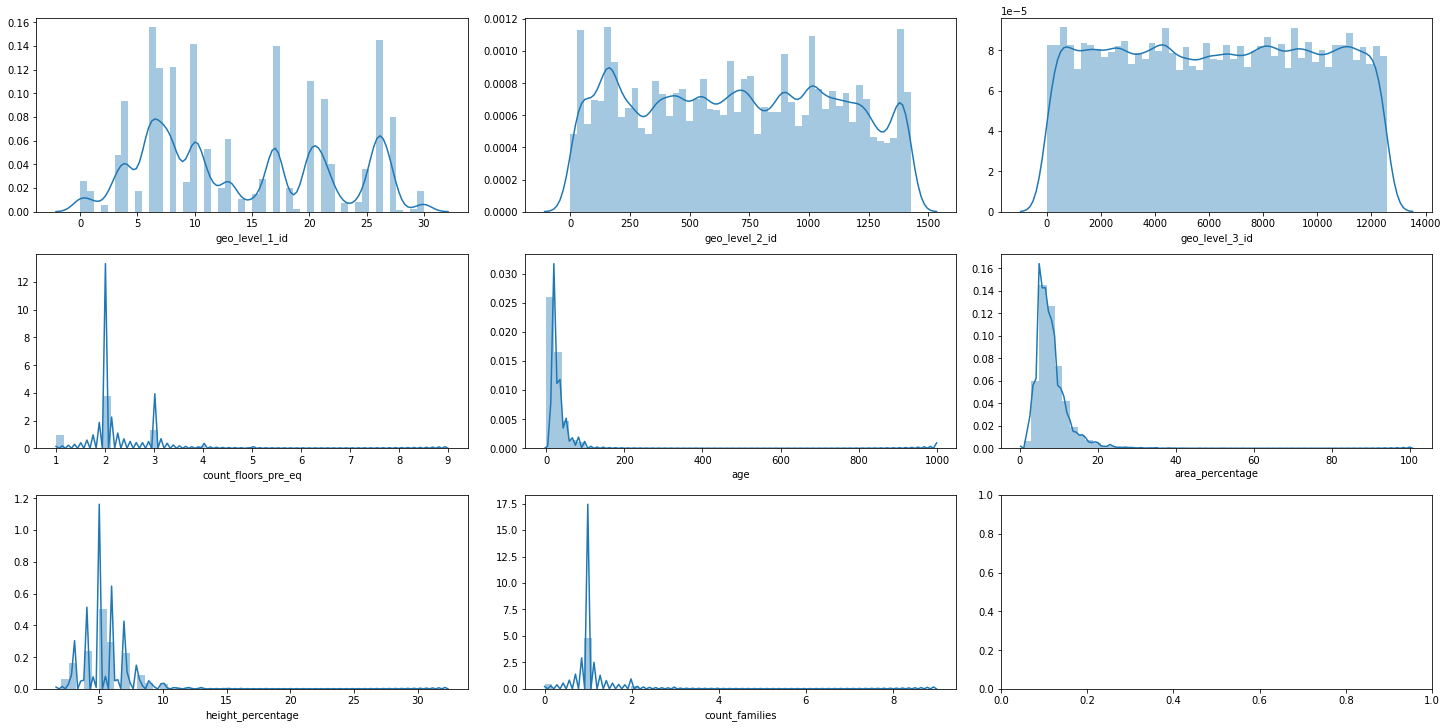

In [12]:
#distribution plot of numeric except binary variables

fig, axes = plt.subplots(math.ceil(len(non_bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten()
for ax,col in zip(axes,non_bin_cols):
        sns.distplot(df[col],ax=ax)

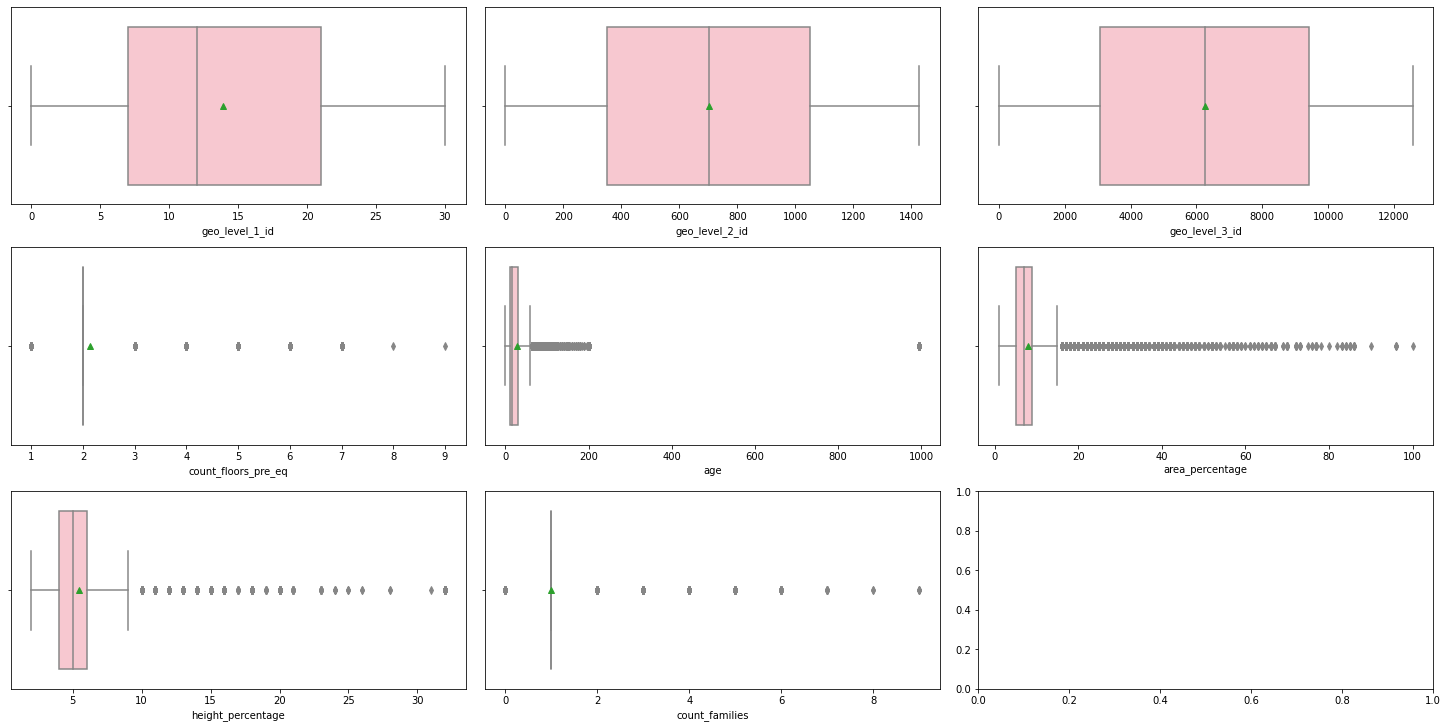

In [13]:
fig, axes = plt.subplots(math.ceil(len(non_bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten() 

for ax,col in zip(axes,non_bin_cols):
    sns.boxplot(df[col],ax=ax,color='pink',showmeans=True)


In [14]:
for col in (cat_cols):
  display(df[col].value_counts())
  print("*"*70)

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

**********************************************************************


r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

**********************************************************************


n    182842
q     61576
x     16183
Name: roof_type, dtype: int64

**********************************************************************


f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64

**********************************************************************


q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64

**********************************************************************


s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64

**********************************************************************


d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

**********************************************************************


v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64

**********************************************************************


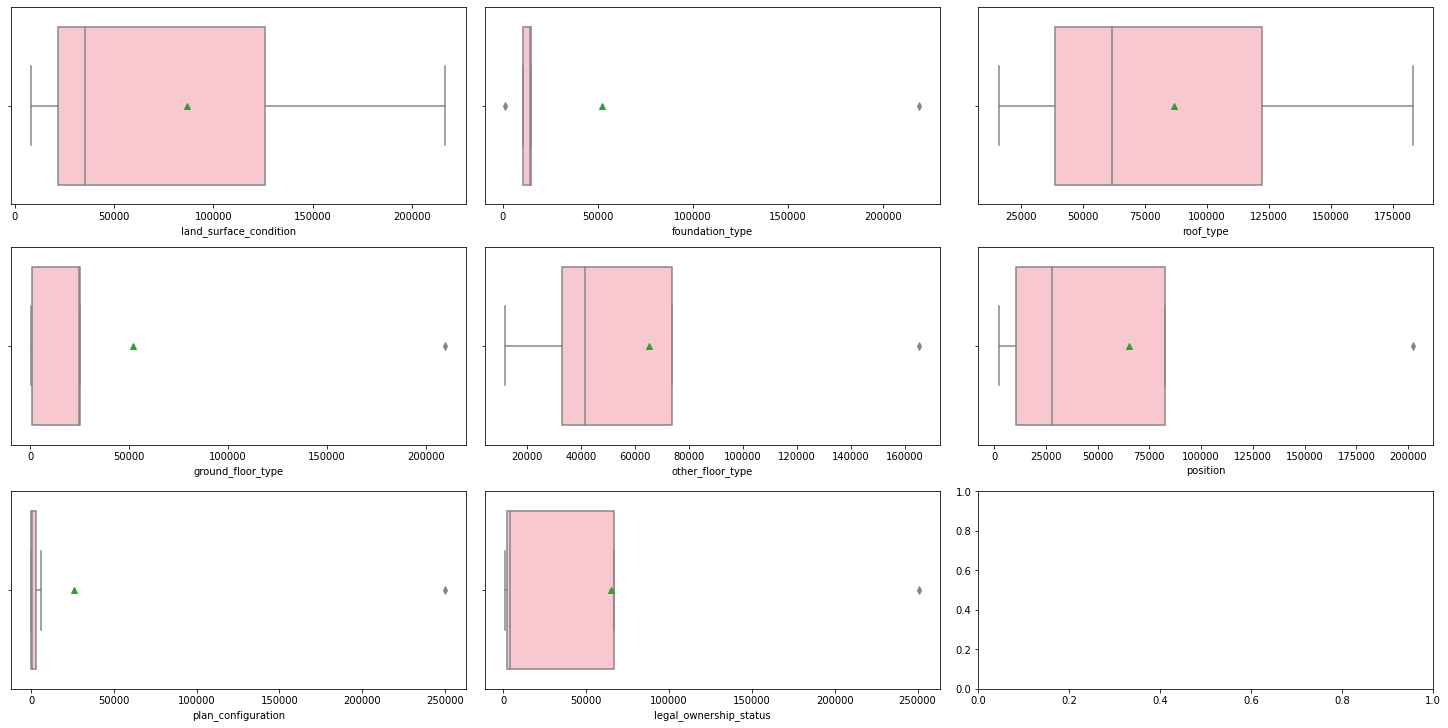

In [15]:
fig, axes = plt.subplots(math.ceil(len(cat_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten() 

for ax,col in zip(axes,cat_cols):
    sns.boxplot(df[col].value_counts(),ax=ax,color='pink',showmeans=True)


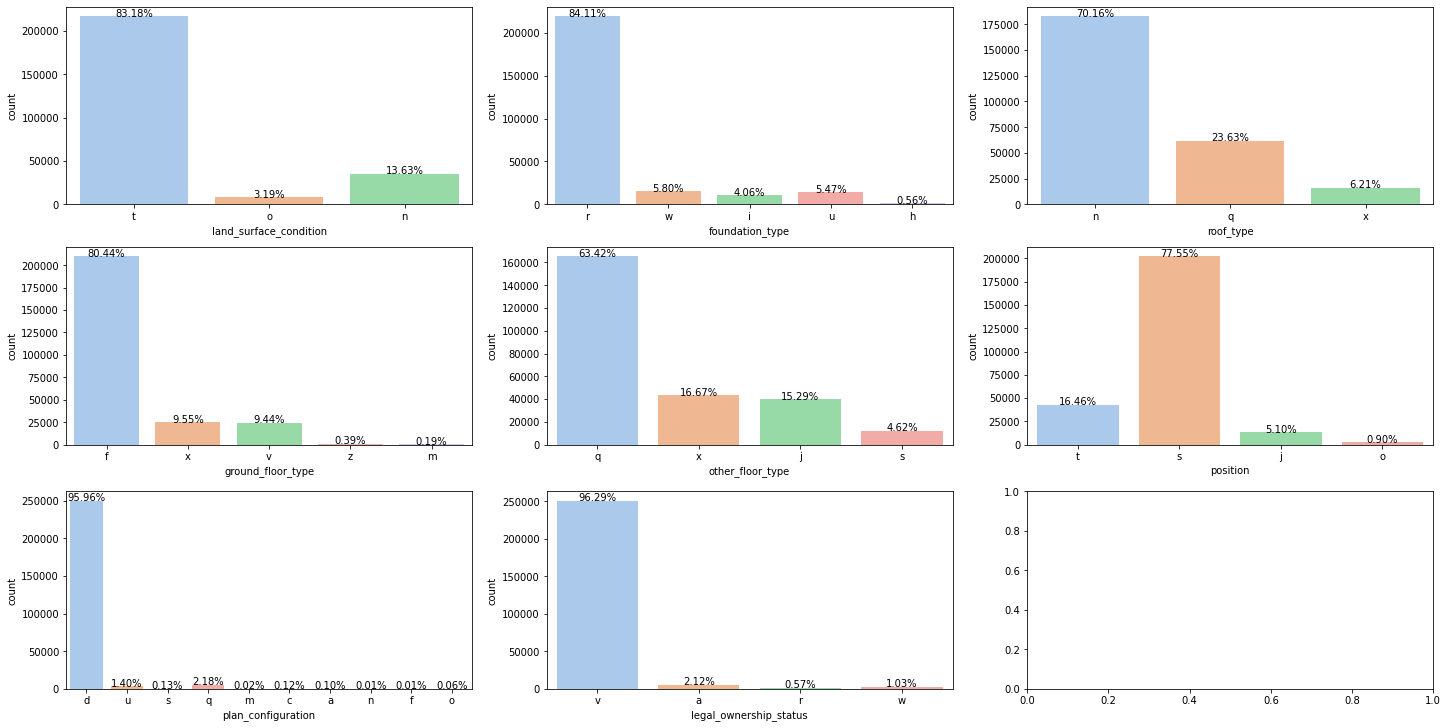

In [16]:
fig, axes = plt.subplots(math.ceil(len(cat_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten() 

for ax,col in zip(axes,cat_cols):
    total=len(df[col])
    sns.countplot(df[col],ax=ax,palette='pastel')
    for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

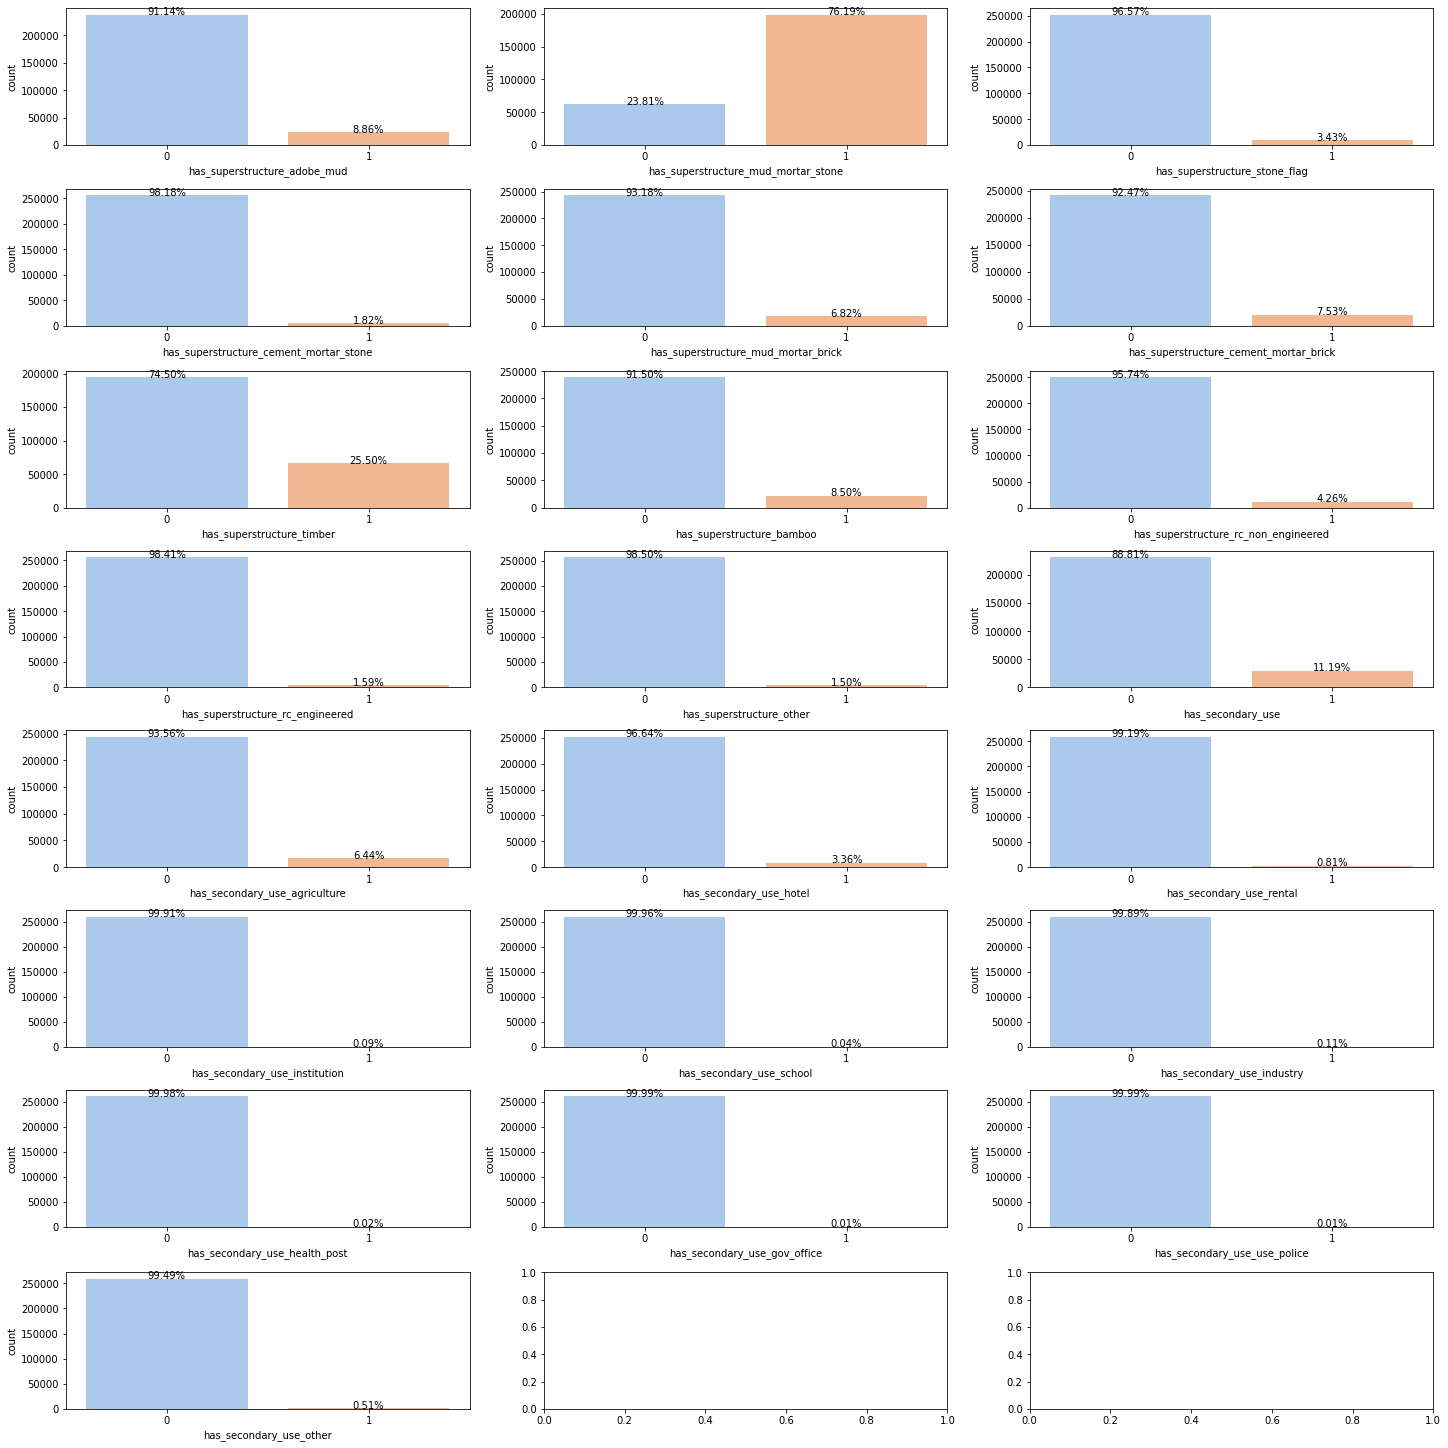

In [17]:
fig, axes = plt.subplots(math.ceil(len(bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 20))
axes = axes.flatten() 

for ax,col in zip(axes,bin_cols):
    total=len(df[col])
    sns.countplot(df[col],ax=ax,palette='pastel')
    for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

In [0]:
#corrected axis issue in heatmap
#plt.figure(figsize=(20,20))
#ax = sns.heatmap(df.corr(), annot=True, fmt='.2f') #notation: "annot" not "annote"
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

(31.5, -0.5)

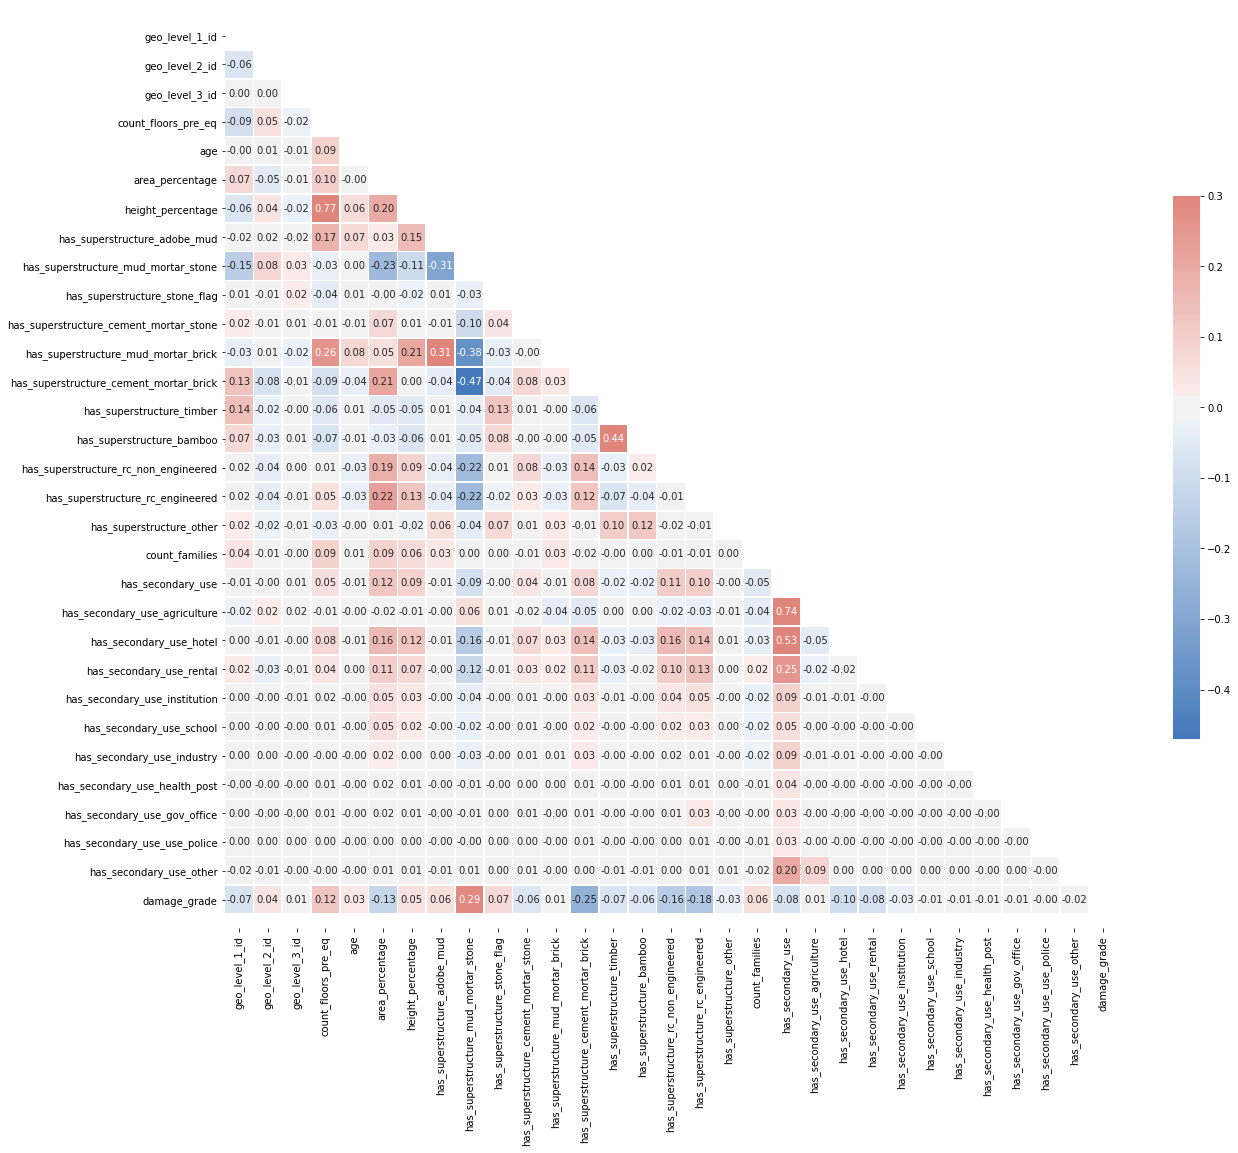

In [19]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

###Correlation

floor count and height +ve cor, height can be removed after feat eng
SS_mud_mortar_stone +ve cor with target and SS_cement_mortar_brick -ve cor with target

SS_mud_mortar_brick +ve with floor count, can be indication of strong foundation
SS_rc +ve with area





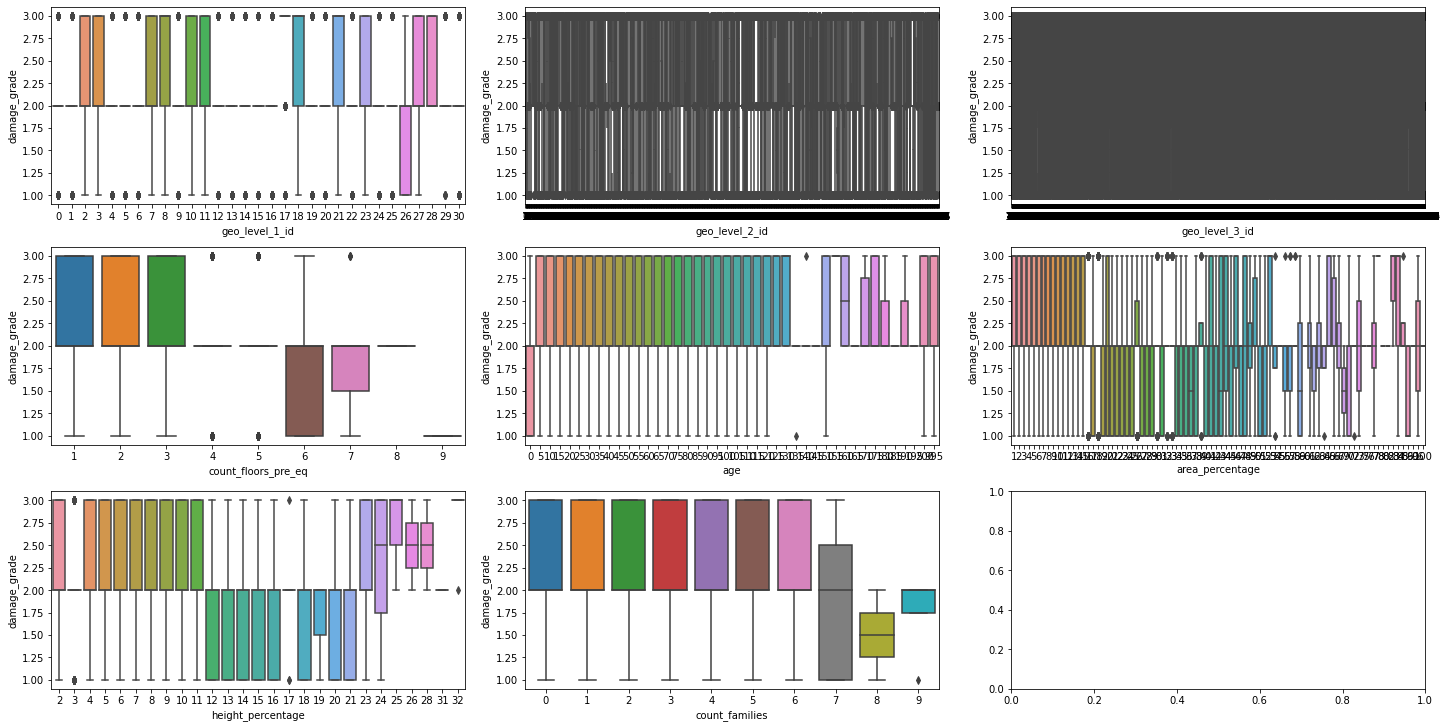

In [20]:
#distribution of numeric columns with target

fig, axes = plt.subplots(math.ceil(len(non_bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten()
for ax,col in zip(axes,non_bin_cols):
  sns.boxplot(df[col],y=df['damage_grade'],ax=ax)

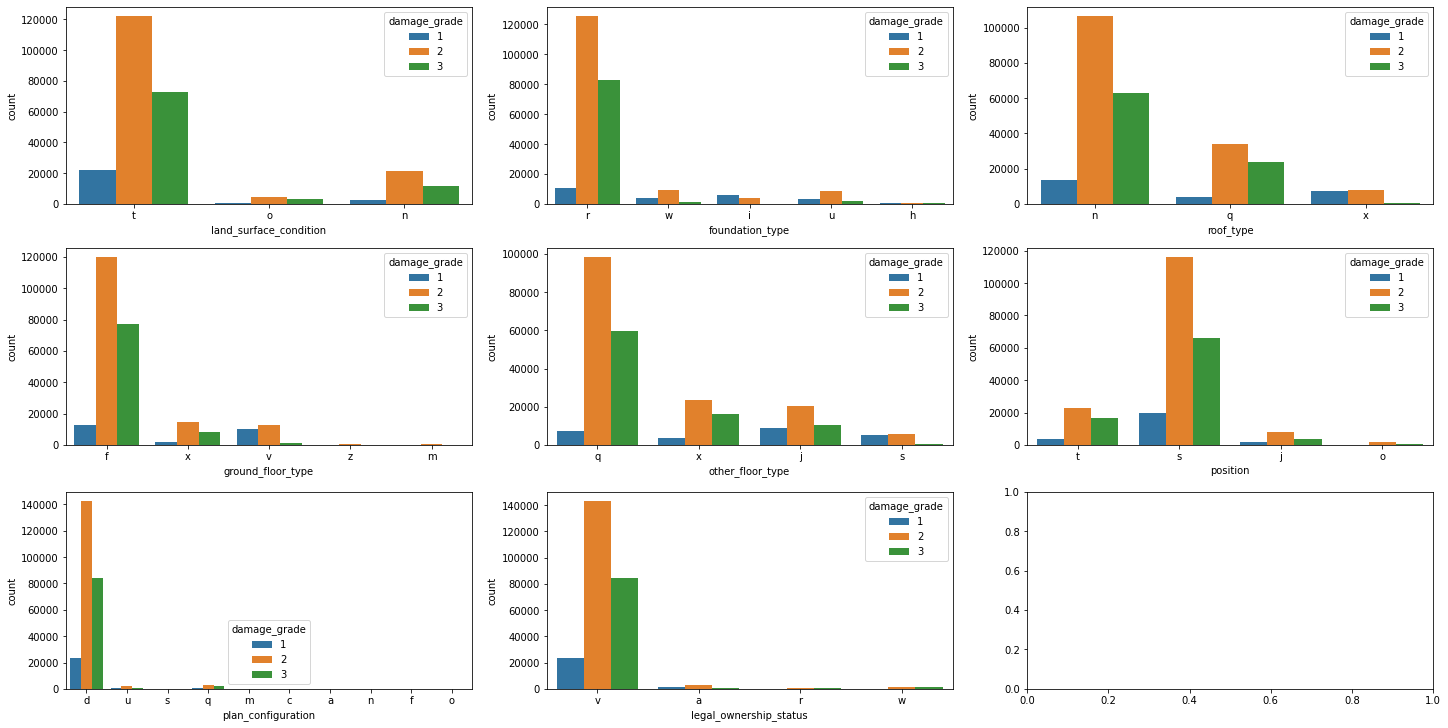

In [21]:
fig,axes=plt.subplots(math.ceil(len(cat_cols)/3),3,constrained_layout=True,figsize=(20,10))
ax=axes.flatten()
for ax,col in zip(ax,cat_cols):
  sns.countplot(df[col],hue=df['damage_grade'],ax=ax)

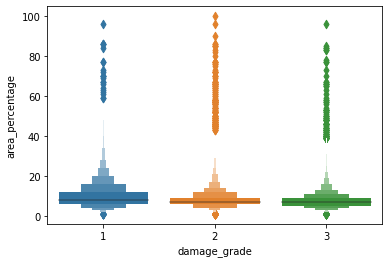

In [22]:
sns.boxenplot(df['damage_grade'],df['area_percentage'])

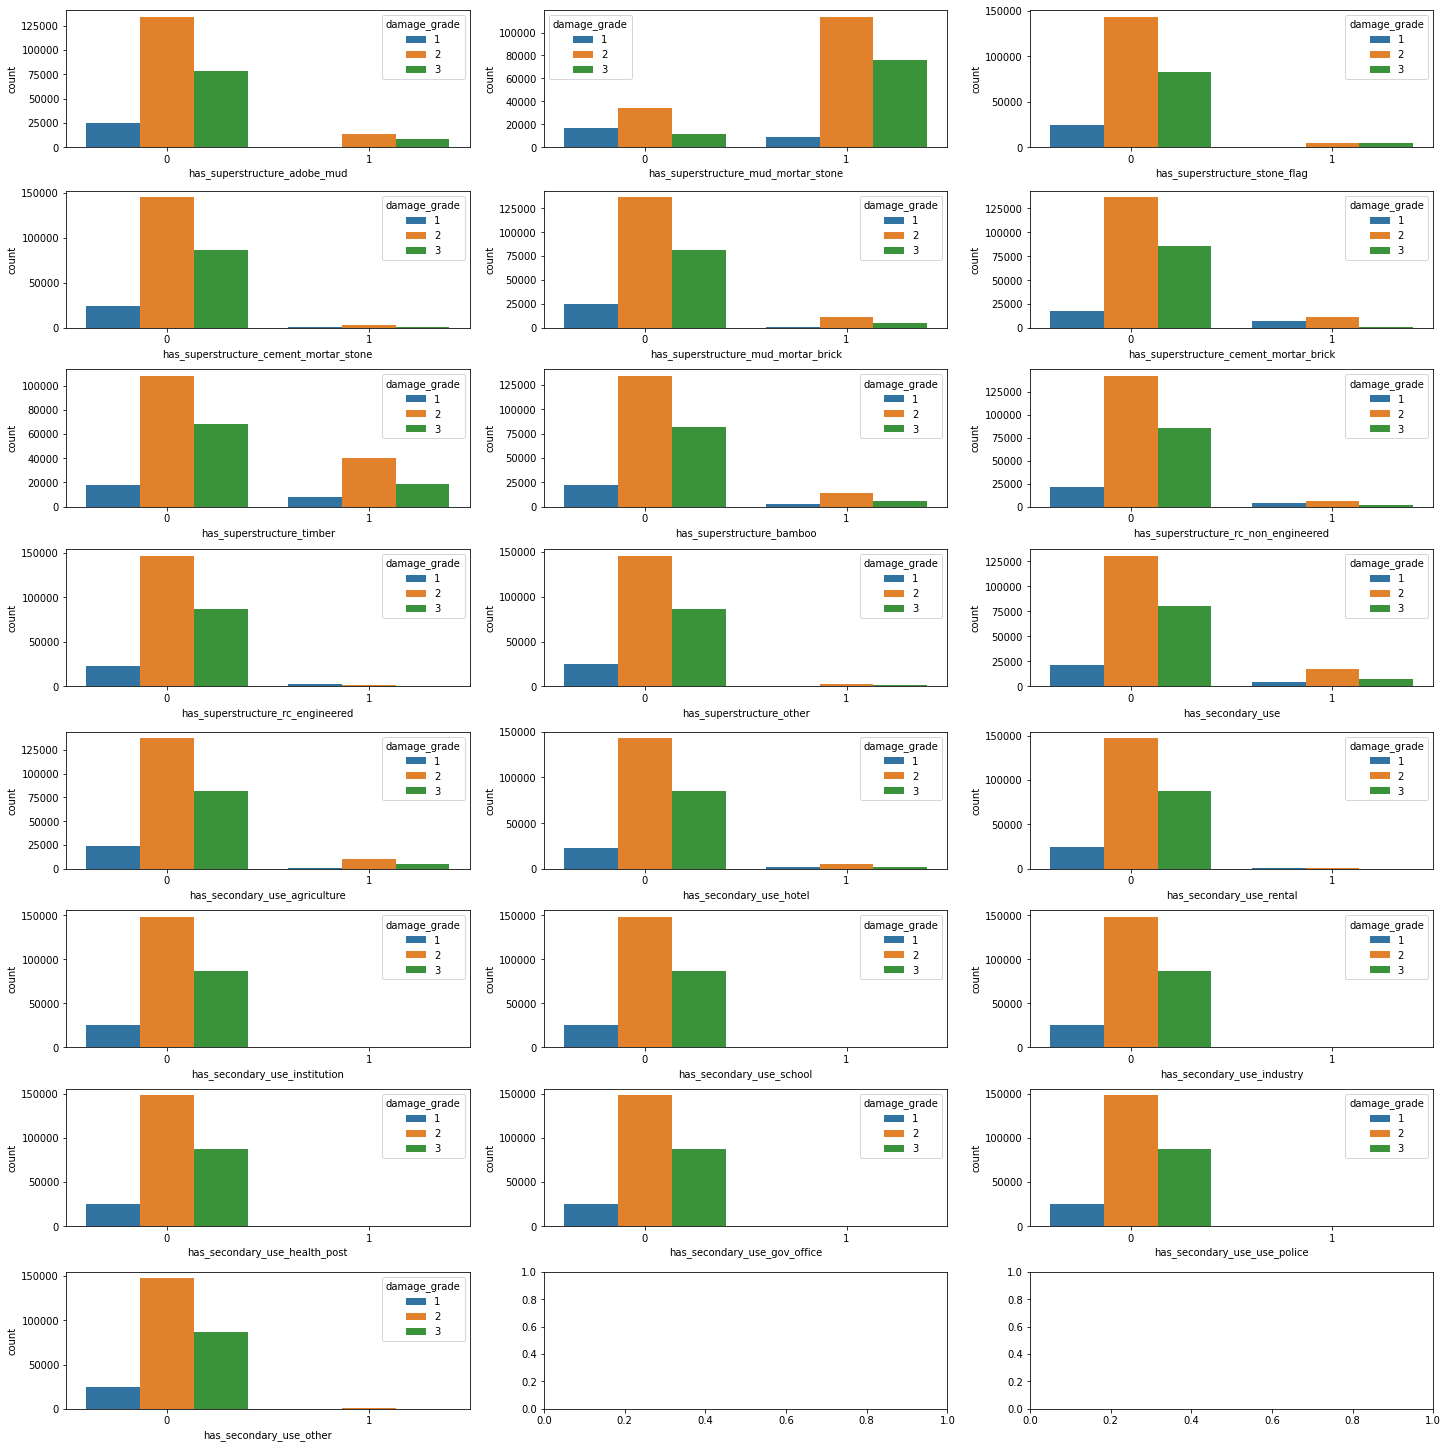

In [23]:
fig,axes=plt.subplots(math.ceil(len(bin_cols)/3),3,constrained_layout=True,figsize=(20,20))
ax=axes.flatten()
for ax,col in zip(ax,bin_cols):
  sns.countplot(df[col],hue=df['damage_grade'],ax=ax)
#Every dist has damage 2 as the most count


In [24]:
df.groupby(['geo_level_1_id']).count()['damage_grade'].sort_values(ascending=False)

geo_level_1_id
6     24381
26    22615
10    22079
17    21813
8     19080
7     18994
20    17216
21    14889
4     14568
27    12532
13     9608
11     8220
3      7540
22     6252
25     5624
16     4332
0      4011
9      3958
12     3194
18     3189
1      2701
5      2690
30     2686
15     2320
14     1714
24     1310
23     1121
2       931
29      396
19      372
28      265
Name: damage_grade, dtype: int64

In [25]:
df.groupby(['geo_level_2_id','geo_level_1_id']).count()['damage_grade'].sort_values(ascending=False).head(60)

geo_level_2_id  geo_level_1_id
39              26                4038
158             20                2520
181             27                2080
1387            3                 2040
157             7                 1897
363             21                1760
463             8                 1740
673             6                 1704
533             27                1684
883             11                1626
1394            27                1537
548             27                1497
1006            3                 1450
720             3                 1359
991             26                1145
1001            26                1135
889             25                1114
765             11                1091
1253            6                 1090
1155            27                1069
1401            26                1063
886             26                1053
151             10                1043
660             11                1041
131             11               

In [26]:
df.groupby(['geo_level_3_id','geo_level_2_id','geo_level_1_id']).count()['damage_grade'].sort_values(ascending=False).head(60)

geo_level_3_id  geo_level_2_id  geo_level_1_id
633             39              26                651
9133            39              26                647
621             158             20                530
11246           39              26                470
2005            39              26                466
11440           39              26                455
7723            151             10                443
9229            158             20                381
2452            158             20                349
12258           1001            26                312
8236            463             8                 303
10445           39              26                302
6626            1001            26                283
2170            991             26                283
2537            363             21                259
85              39              26                252
406             1166            7                 251
6973            463             8  

In [27]:
df_ss = df[['has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']]
df_ss['sum']=0
df_ss['sum']=df_ss.sum(axis=1) 
df_ss.loc[590882]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       1
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 1
has_superstructure_bamboo                 1
has_superstructure_rc_non_engineered      0
has_superstructure_rc_engineered          0
has_superstructure_other                  0
sum                                       3
Name: 590882, dtype: int64

In [28]:

pd.Series(df_ss.sum(axis=1) )

building_id
802906    4
28830     2
94947     2
590882    6
201944    2
         ..
688636    2
669485    2
602512    2
151409    2
747594    2
Length: 260601, dtype: int64

In [0]:
#melt_df=pd.melt(df.iloc[:, list(range(3)) + [-1]].head(10),id_vars='damage_grade',var_name='geo_level')
#melt_df.groupby(['damage_grade'])[['geo_level','value']].groups
#sns.swarmplot(x='geo_level_1_id', data=df.head(50), y='damage_grade')
#melt_df  

In [30]:
t=pd.melt(df.iloc[:,14:25].head(30).reset_index(),id_vars='building_id',var_name='SS')
t[t['value']==1].sort_values('building_id')
t.groupby(['building_id'])[['SS','value']].agg(np.sum)
#try with target

,value
building_id,
7962,2
28830,1
94947,1
201944,1
219578,2
287845,2
333020,1
354011,1
433870,1


In [0]:
X=df.iloc[:,:-1]
#y=df.iloc[:,-1:]
y=df['damage_grade']

In [0]:
#label encoding
encoder = LabelEncoder()
for col in cat_cols:
    X[col] = encoder.fit_transform(X[col])

In [0]:
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42,test_size =0.2)

In [0]:
#Basic logreg model
logreg=LogisticRegression(max_iter=10000,solver='sag')
#logreg.fit(X_train,y_train)
#y_pred=logreg.predict(X_test)
#print(logreg.score(X_test,y_test))
#print("Micro f1 = " , f1_score(y_test,y_pred,average='micro'))

In [35]:
rf_clf=RandomForestClassifier(n_estimators=100,n_jobs=100,random_state=0)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=100, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [36]:
y_pred=rf_clf.predict(X_test)
print("Micro f1 = " , f1_score(y_test,y_pred,average='micro'))

Micro f1 =  0.7198825809174805


In [0]:
#Test label encoding
encoder = LabelEncoder()
for col in cat_cols:
    df_test[col] = encoder.fit_transform(df_test[col])

In [0]:
df_test.set_index('building_id',inplace=True)
df_test['damage_grade']=rf_clf.predict(df_test)


In [0]:
df_test.reset_index(inplace=True)
test=df_test[['building_id','damage_grade']]



In [40]:
#drive.mount('/drive')
#test.to_csv('/drive/My Drive/Colab Notebooks/Submission_file.csv',index=False)
test.to_csv('Submission_file.csv',index=False)
print("Submission file created with columns", test.columns)
#files.download('Submission_file.csv')

Submission file created with columns Index(['building_id', 'damage_grade'], dtype='object')


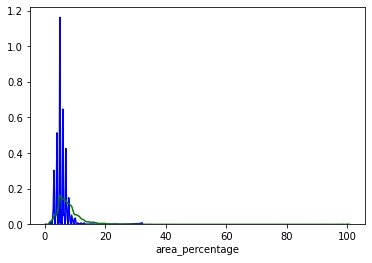

In [41]:

ax_height=sns.distplot(df['height_percentage'],color='b',hist=False)
ax_area=sns.distplot(df['area_percentage'],color='g',hist=False)

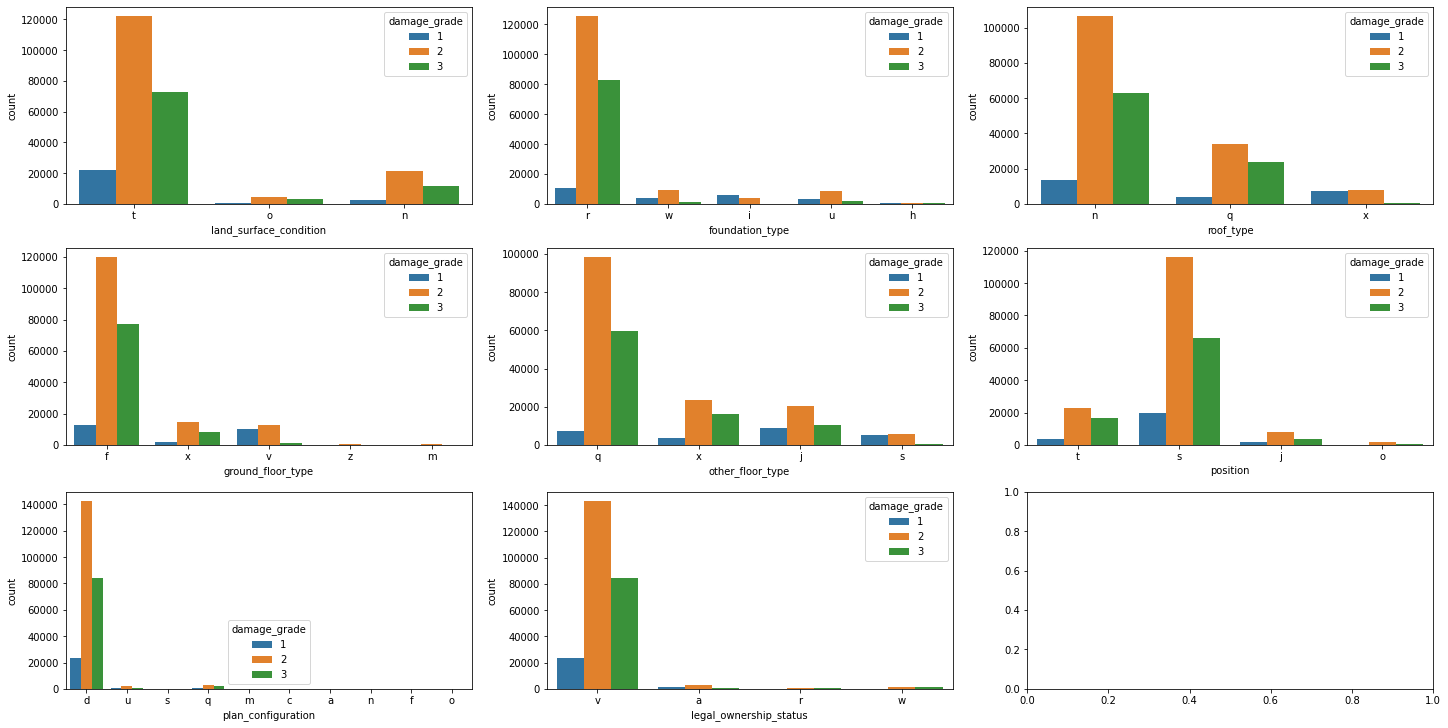

In [42]:
fig,axes=plt.subplots(math.ceil(len(cat_cols)/3),3,constrained_layout=True,figsize=(20,10))
ax=axes.flatten()
for ax,col in zip(ax,cat_cols):
  sns.countplot(df[col],hue=df['damage_grade'],ax=ax)

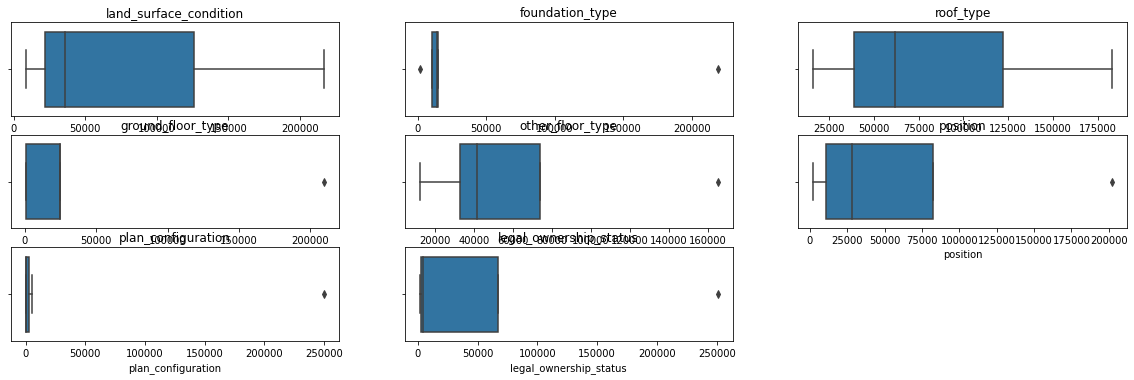

In [43]:
cat={'land_surface_condition':1,
 'foundation_type':2,
 'roof_type':3,
 'ground_floor_type':4,
 'other_floor_type':5,
 'position':6,
 'plan_configuration':7,
 'legal_ownership_status':8}
plt.figure(figsize=(20,10))
for variable,i in cat.items():
  plt.subplot(5,3,i)
  sns.boxplot(df[variable].value_counts(),whis=1.5)
  plt.title(variable)